In [51]:
import os
import pandas as pd
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import math
import warnings
warnings.filterwarnings("ignore")

In [52]:
os.chdir(r"C:\Users\me19b\OneDrive\Desktop\PRML_assignment_2")
os.getcwd()
dataset_pd = pd.read_csv('A2Q1.csv',header = None)
dataset_pd.columns=['feature_1']

In [53]:
dataset_pd

,feature_1
0,0.57539
1,7.69890
2,5.17310
3,1.00350
4,0.21469
...,...
995,39.90800
996,2.77390
997,4.18190
998,63.89000


In [54]:
dataset = dataset_pd.to_numpy()

In [55]:
# function to get initial means
def initial_means(data,Number_of_clus,mean):
    minimum_distance = []
    maximum_distance = []
    for k in range(1,Number_of_clus):
        for i in range(0,len(data)):
            for j in range(0,len(mean)):
                minimum_distance.append(np.linalg.norm(data[i]-np.array(mean[j])))
            maximum_distance.append(min(minimum_distance))
            minimum_distance = []
        mean.append(list(np.array((data[maximum_distance.index(max(maximum_distance))]))))
        maximum_distance = []
    return mean

#forming new clusters with cluster function
def cluster(data, mean, Number_of_clus):
    near_mean = []
    Z = []
    clust_no = []
    err = 0
    #creating empty list for cluster division
    for i in range(0,Number_of_clus):
        Z.append([])
    for i in range(0,len(dataset)):
        #calculating the distance from data points to all means
        for j in range(0,Number_of_clus):
            distance = data[i]-np.array(mean[j])
            near_mean.append(distance@distance.transpose())
        #appending the cluster number of data point to k in correspoding index
        clust_no.append(near_mean.index(min(near_mean))+1)
        #clustering the data points to their respective cluster
        Z[near_mean.index(min(near_mean))].append(list(data[i]))
        #calculating error
        err = err+min(near_mean)
        near_mean = []
    return Z,clust_no,err

#Calculating new mean for the clusters from the above function 
def new_cluster_mean(Z,Number_of_clus):
    #Claculating mean of the same clusters
    new_mean = []
    new_variance = []
    phi  = []
    for i in range(0,Number_of_clus):
        for j in range(0,len(np.array(Z[i]).transpose())):
            new_mean.append((np.array(Z[i])[:,j]).mean())
            new_variance.append((np.array(Z[i])[:,j]).var())
            phi_no=len(np.array(Z[i])[:,j])/1000
            phi.append(phi_no)
    return new_mean,new_variance,phi

#Finding Final Clusters, means, error
def final(data,Number_of_clus,idx):
    means = []
    means.append(list(data[idx]))
    first_means = initial_means(data,Number_of_clus,means)
    first_means.sort()
    
    error_list = []
    cluster_1, k1, error = cluster(data,first_means,Number_of_clus)
    error_list.append(error)
    k_t = k1
    mean_t,variance_t,phi_t = new_cluster_mean(cluster_1,Number_of_clus)
    while(True):
        cluster_t1, k_t1,error = cluster(data,mean_t,Number_of_clus)
        mean_t1,variance_t1,phi_t1 = new_cluster_mean(cluster_t1,Number_of_clus)
        if k_t1 != k_t:
            k_t = k_t1
            cluster_t = cluster_t1
            mean_t = mean_t1
            variance_t =variance_t1
            phi_t = phi_t1
            error_list.append(error)
        else: 
            break
    return k_t,mean_t,variance_t,phi_t,error_list

<AxesSubplot:xlabel='feature_1'>

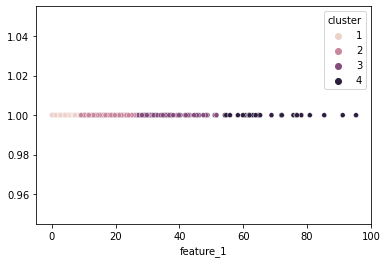

In [56]:
#initialization of parameters
Number_of_clus = 4
idx = 256
cluster_number,mean_t,variance_t,phi_t,error_list = final(dataset,Number_of_clus,idx)
dataset_pd = pd.DataFrame(dataset)
dataset_pd.columns = ['feature_1']
z = pd.DataFrame(cluster_number)
z.columns = ['cluster']
dataset_pd = pd.concat([dataset_pd,z],axis=1)
sns.scatterplot(x=dataset_pd.feature_1,y=1,hue = dataset_pd.cluster, s = 25)

In [57]:
print(mean_t)
print(variance_t)
print(phi_t)

[1.720094044440415, 16.20715899280576, 36.41782812500001, 68.84516]
[4.285966731213187, 20.709519438678118, 46.871407611083995, 120.85994381440001]
[0.772, 0.139, 0.064, 0.025]


In [58]:
idx = np.array(mean_t).argsort()
mean_t = np.array(mean_t)[idx]
print(idx)
mean_t

[0 1 2 3]


array([ 1.72009404, 16.20715899, 36.41782813, 68.84516   ])

In [59]:
variance_t = np.array(variance_t)[idx]
print(idx)
variance_t

[0 1 2 3]


array([  4.28596673,  20.70951944,  46.87140761, 120.85994381])

In [60]:
phi_t = np.array(phi_t)[idx]
phi_t

array([0.772, 0.139, 0.064, 0.025])

# Determine which probabilisitic mixture could have generated this data (It is not a Gaussian mixture). Derive the EM algorithm for your choice of mixture and show your calculations. Write a piece of code to implement the algorithm you derived by setting the number of mixtures K = 4. Plot the log-likelihood (averaged over 100 random initializations) as a function of iterations.

In [61]:
# functions for likelihood, lamda and parameters
def likelihood_1(dataset,teta_a,phi_t):
    log_l = np.empty([1000,4])
    log_l_columns=[]
    likelihood =[]
    for i in range(0,len(dataset)):
        for j in range(0,Number_of_clus):
            log_l[i][j] = ((phi_t[j])*teta_a[j]*math.exp(-(dataset[i]*teta_a[j])))
        log_l_columns.append(math.log(round(log_l[i,:].sum(),20)))
    likelihood.append(sum(log_l_columns))
    return likelihood

def lamda_1(dataset,teta_a,phi_t):
    l=np.empty([1000,4])
    l_d=np.empty([1000,4])
    l_denomenator=[]
    for i in range(0,len(dataset)):
        for k in range(0,Number_of_clus):
            l_d[i][k]= ((phi_t[k])*teta_a[k]*math.exp(-(dataset[i]*teta_a[k])))
        l_denomenator.append(l_d[i,:].sum())    
    for i in range(0,len(dataset)):
        for j in range(0,Number_of_clus):
            l[i][j] = (((phi_t[j])*teta_a[j]*math.exp(-(dataset[i]*teta_a[j])))/l_denomenator[i])
    return l  
                           
def parameters_1(dataset,l_teta):
    m=np.empty([1000,4])
    d=np.empty([1000,4])
    n=1000
    teta_a_t1 = []
    phi_t1 = []
    for i in range(0,Number_of_clus):
        for j in range(0,len(dataset)):
            m[j][i] = (dataset[j]*l_teta[j][i])
            d[j][i]= (l_teta[j][i])
        teta_a_t1.append((d[:,i].sum())/(m[:,i].sum()))
        phi_t1.append((d[:,i].sum())/n)
    return teta_a_t1,phi_t1 

In [62]:
#100 random initialisations
def random_initialisation(dataset,Number_of_clus):
    mean_random = np.empty([100,4])
    variance_random = np.empty([100,4])
    phi_random = np.empty([100,4])
    mean_r = []
    variance_r = []
    phi_r = []
    mean_final = []
    variance_final = []
    phi_final = []
    x1= [x1 for x1 in range(1,1000,10)]
    for i in range(0,100):
        cluster_no,mean_r,variance_r,phi_r,error_list_r = final(dataset,Number_of_clus,x1[i])
        mean_random[i] = mean_r
        variance_random[i] = variance_r
        phi_random[i] = phi_r
    for j in range(0,Number_of_clus):
        mean_final.append(mean_random[:,j].mean())
        variance_final.append(variance_random[:,j].mean())
        phi_final.append(phi_random[:,j].mean())
    return mean_final,variance_final,phi_final
        
    
        
        
        

In [63]:
mean_t,variance_t,phi_t= random_initialisation(dataset,Number_of_clus)

In [64]:
mean_t

[1.7200940444404145, 16.207158992805763, 36.41782812500002, 68.84515999999999]

In [65]:
#loop to find log likelihood until convergence
logl_a = []
s=1
y_a=[]
y_a.append(s)
dataset_pd = pd.read_csv('A2Q1.csv',header = None)
dataset_pd.columns=['feature_1']
dataset = dataset_pd.to_numpy()
Number_of_clus = 4
idx = 256
#iteration 1
mean_t,variance_t,phi_t= random_initialisation(dataset,Number_of_clus)
teta_a_t = list(1/np.array(mean_t))
likelihood_t_a = likelihood_1(dataset,teta_a_t,phi_t)
logl_a.append(float(np.array(likelihood_t_a)))


while(True):
    lamda_t_1 = lamda_1(dataset,teta_a_t,phi_t)
    tetaA_t_1,phi_t_1 = parameters_1(dataset,lamda_t_1)
    tetaA_norm = np.linalg.norm(np.array(tetaA_t_1)-np.array(teta_a_t))
    phi_norm = np.linalg.norm(np.array(phi_t_1) - np.array(phi_t))
    print(tetaA_norm,phi_norm)
    #convergence condition
    if max(tetaA_norm,phi_norm)>0.0001:
        teta_a_t=tetaA_t_1
        phi_t = phi_t_1
        likelihood_t = likelihood_1(dataset,teta_a_t,phi_t)
        logl_a.append(float(np.array(likelihood_t)))
        s=s+1
        y_a.append(s)

    else:
        break
print(y_a)
print(s)
print(logl_a)
print(len(logl_a))

0.09440820215270705 0.08352077946801459
0.10590399834121375 0.041751496032487116
0.0847745994766689 0.027867552350518215
0.058233778129379056 0.019067400861927458
0.03696915831805585 0.012711681876391243
0.022776180905802967 0.008234097325162684
0.013928042418967541 0.0052220159079391865
0.008515926075733562 0.003266465983572133
0.00521302352062529 0.0020249249872034067
0.0031936948866880506 0.001247004263838967
0.0019567474785189723 0.000763312783997054
0.0011982968493647623 0.0004639754307937398
0.0007334435117231188 0.00027934209934181133
0.0004493780095824773 0.0001658402119987242
0.00027725403943396076 9.646133190093453e-05
0.00017514772717738507 5.4667341316049415e-05
0.00011741917116084373 3.067777975208084e-05
8.756044783898776e-05 1.9201110597093025e-05
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
18
[-2635.1881526695656, -2592.1711706228593, -2574.128382068638, -2565.9805401364197, -2562.643222760488, -2561.349216787428, -2560.8569179249957, -2560.670460489

Text(0.5, 1.0, 'plot of log likelihood function for a probabilistic mixture')

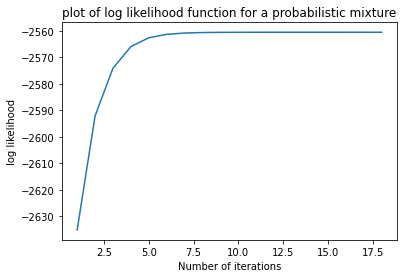

In [66]:
#plot of log likelihood function for a probabilistic mixture
plt.plot(y_a,logl_a)
plt.xlabel('Number of iterations')
plt.ylabel('log likelihood')
plt.title('plot of log likelihood function for a probabilistic mixture')

# Assume that the same data was infact generated from a mixture of Gaussians with 4 mixtures. Implement the EM algorithm and plot the log-likelihood (averaged over 100 random initializations of the parameters) as a function of iterations. How does the plot compare with the plot from part (i)? Provide insights that you draw from this experiment.

In [67]:
#function to calculate likelihood for gaussian distribution
def likelihood(dataset,mean_t,variance_t,phi_t):
    log_l = np.empty([1000,4])
    log_l_columns=[]
    likelihood =[]
    for i in range(0,len(dataset)):
        for j in range(0,Number_of_clus):
            log_l[i][j] = (((2*math.pi*variance_t[j])**(-0.5))*(phi_t[j])*math.exp(-((dataset[i]-mean_t[j])**2)/(2*variance_t[j])))
        log_l_columns.append(math.log(round(log_l[i,:].sum(),20)))
    likelihood.append(sum(log_l_columns))
    return likelihood

In [68]:
#function for lamda
#lamda_0 = ((2*np.pi*np.array(variance_t))**(-0.5))*np.array(phi_t)
Number_of_clus = 4
def lamda(dataset,mean_t,variance_t,phi_t):
    l=np.empty([1000,4])
    l_d=np.empty([1000,4])
    l_denomenator=[]
    for i in range(0,len(dataset)):
        for k in range(0,Number_of_clus):
            l_d[i][k]= (((2*np.pi*variance_t[k])**(-0.5))*(phi_t[k])*math.exp(-((dataset[i]-mean_t[k])**2)/(2*variance_t[k])))
        l_denomenator.append(l_d[i,:].sum())        
    for i in range(0,len(dataset)):
        for j in range(0,Number_of_clus):
            l[i][j] = (((2*np.pi*variance_t[j])**(-0.5))*(phi_t[j])*math.exp(-((dataset[i]-mean_t[j])**2)/(2*variance_t[j])))/l_denomenator[i]
    return l  

In [69]:
#function for mean,variance,phi
def parameters(dataset,l_teta):
    m=np.empty([1000,4])
    d=np.empty([1000,4])
    n=1000
    mean_t1 = []
    phi_t1 = []
    for i in range(0,Number_of_clus):
        for j in range(0,len(dataset)):
            m[j][i] = (dataset[j]*l_teta[j][i])
            d[j][i]= (l_teta[j][i])
        mean_t1.append((m[:,i].sum())/(d[:,i].sum()))
        phi_t1.append((d[:,i].sum())/n)
    return mean_t1,phi_t1  

def variance_teta(dataset,l_teta,mean_t1):
    m_1=np.empty([1000,4])
    d=np.empty([1000,4])
    variance_t1=[]
    for i in range(0,len(dataset)):
        for j in range(0,Number_of_clus):
            m_1[i][j] = l_teta[i][j]*(dataset[i]-mean_t1[j])**2
    for i in range(0,Number_of_clus):
        variance_t1.append((m_1[:,i].sum())/(l_teta[:,i].sum()))
    return variance_t1 

In [70]:
logl = []
a=1
y=[]
y.append(a)
dataset_pd = pd.read_csv('A2Q1.csv',header = None)
dataset_pd.columns=['feature_1']
dataset = dataset_pd.to_numpy()
Number_of_clus = 4
idx = 256
mean_t1,variance_t1,phi_t1 = random_initialisation(dataset,Number_of_clus)
likelihood_t = likelihood(dataset,mean_t1,variance_t1,phi_t1)
logl.append(float(np.array(likelihood_t)))


while(True):
    lamda_t_1 = lamda(dataset,mean_t1,variance_t1,phi_t1)
    mean_t_1,phi_t_1 = parameters(dataset,lamda_t_1)
    variance_t_1 = variance_teta(dataset,lamda_t_1,mean_t_1)
    mean_norm = np.linalg.norm(np.array(mean_t_1)-np.array(mean_t1))
    variance_norm = np.linalg.norm(np.array(variance_t_1) - np.array(variance_t1))
    phi_norm = np.linalg.norm(np.array(phi_t_1) - np.array(phi_t1))
    if max(mean_norm,variance_norm,phi_norm)>0.0001:
        mean_t1=mean_t_1
        variance_t1=variance_t_1
        phi_t1 = phi_t_1
        likelihood_t = likelihood(dataset,mean_t_1,variance_t_1,phi_t_1)
        logl.append(float(np.array(likelihood_t)))
        a=a+1
        y.append(a)

    else:
        break
print(y)
print(a)
print(logl)
print(len(logl))


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172]
172
[-3060.145383298287, -2980.7576664411076, -2880.662228919003, -2802.953527534467, -2768.259394850531, -2752.0915156340056, -2743.5412722176557, -2738.4931126207603, -2735.195097016464, -2732.84834732913, -2731.048068210366, -2729.572348363269,

Text(0.5, 1.0, 'plot of log likelihood function for a gaussian distribution')

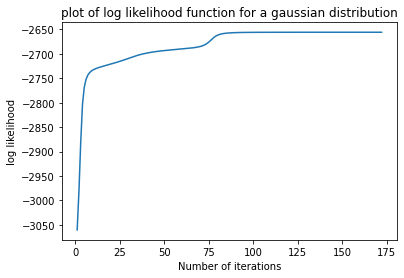

In [72]:
#plot of log likelihood function for a gaussian distribution
plt.plot(y,logl)
plt.xlabel('Number of iterations')
plt.ylabel('log likelihood')
plt.title('plot of log likelihood function for a gaussian distribution')

# Run the K-means algorithm with K = 4 on the same data. Plot the objective of K − means as a function of iterations.

In [73]:
Number_of_clus = 4
idx = 256
k_e,mean_e,variance_e,phi_e,error_list_e = final(dataset,Number_of_clus,idx)

In [74]:
error_list_e

[35735.43585023049,
 19717.20915797124,
 18194.290556604523,
 17495.535559142154,
 16823.958428592457,
 15834.725652335062,
 14325.813954986583,
 13592.460695464646,
 13024.886657126543,
 12438.284557971834,
 12233.589721351622]

Text(0.5, 1.0, 'plot of objective of k-means as a function of iterations')

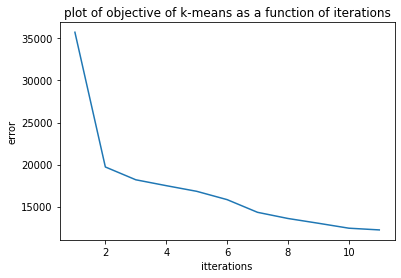

In [75]:
x= [x for x in range(1,len(error_list_e)+1)]
plt.plot(x,error_list_e)
plt.xlabel('itterations')
plt.ylabel('error')
plt.title('plot of objective of k-means as a function of iterations')